<h1 align='center' style='color:purple'>Credit Card Fraud - Imbalanced Data Set</h1>

Winning kaggle notebook: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284
https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

**Use Case:** Credit Card Fraud Detection

    Compare different common algorithms, develop and optimize a new 2 sequential/consecutive model algorithm to see if this can give better results
    
**Author:** Donald Stierman - Senior Data Scientist

**Details:** Imbalanced data can cause issues with most Machine Learning Algorithms and Neural Networks. To alleviate this, I choose to down-sample the training data to use as the input dataset. After creating the down-sampled dataset, I ran this through several different common model algorithms, including a new modeling technique I developed specifically for imbalanced data. I got this idea after reading about some highly effective Healthcare screening solutions currently in use. I.E. Breast Cancer detection in women (see comments: below). If a mammogram comes back positive, we already know that there will be a lot of false positives (benign tumors, scars, etc). Usually the doctor will follow up with a 2nd test, such as biopsy. This will screen out the false positives leaving mostly true positives (cancerous tissue). This same idea can possibly be applied to credit care fraud. We want to catch all true cases of fraud (fraud prevention), to be compliant with government regulations, and additionally not create a huge workload of false cases to be investigated (cost control).

comments:

**Here are some different ways to explain the methodology used in the Healthcare use case:**

*1st test (high specificity) -> 2nd test (high sensitivity) -> Only treat cancerous tissue

*TN/(TN + FP) is high ~ 1    -> TP/(TP + FN) is high ~ 1    -> Find all Positive cases

*catch all possible cases/remove healthy patients -> remove all false flags -> high confidence in Positive result/few missed positives


This same methodology can be applied to Credit Card Fraud detection

Link to code repo at Github:

https://github.com/donaldstierman/imbalanced_data

**Models used:**<pre>
    Logistic Regression
    Random Forest
    Gradient Boosted Decision Trees
    Customized 2 Step Gradient Boosted Decision Trees
    Deep Neural Network
    1D Convolutional Neural Network
    AutoEncoder
</pre>
**Goal:** 
For this example, I chose 2 metrics to optimize, ROC/AUC and best "macro avg recall". I chose these because in the health care example, it is better to catch all cancer patients, even if it means more tests are performed. To compare the results, first objective is to find the best overall model (lowest mislabelled predictions), second is to find the model that has a low number of false negatives (faudulent transactions that are missed) without having too many false positives (genuine transactions that are needlessly investigated)
<pre>
    1) Compare the AUC to find the most robust model of the single step models. However, the value of this metric cannot be calculated directly on the 2 step model, so we need to use #2 below for final comparison
    2) Maximize the Sensitivity (higher priority) or reduce the number of False Negatives (FN/TP ratio) and maximize the Specificity (lower priority) to control the number of tests performed in the 2nd step. I.E. catch all the fraudulent transaction even if there are false flags (false positives).
</pre>
**Results:** The Customized 2 Step model has the best results overall, by only a slight margin. 
                          
                                AUC    Specificity/Sensitivity
                          
    Logistic Regression         .967    .95/.87
    Random Forest               .977    .97/.89  **best AUC**
    Gradient Boosted Tree       .976    .99/.84
    Customized 2 Step GB Trees  NA      .99/.93  **best overall**
    Deep Neural Network         .973    .95/.92  **2nd best overall**
    AutoEncoder                 .954    .88/.93    
    
    
Final Results: ROC Curve comparision

<!-- to save file to html for uploads, use this command: jupyter nbconvert --to html --template basic CreditCardFraud.ipynb -->

In [1]:
# Import Libraries
# try some of these ideas: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
import datetime
import numpy as np
import pandas as pd

import os                                                                                                            
import matplotlib as mpl                                                                                             
if os.environ.get('DISPLAY','') == '':                                                                               
    print('no display found. Using non-interactive Agg backend')                                                     
    mpl.use('Agg')                                                                    
    
import matplotlib.pyplot as plt
if (os.environ.get('TERM','') == 'xterm-color'): 
    %matplotlib inline
elif (os.environ.get('TERM','') == 'cygwin'):
    print("shell terminal found")
else: # 'cygwin'
    print("no terminal found")
    
import pandas_profiling as pp
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer
from matplotlib import pyplot
import zipfile

import tensorflow as tf

StartTime = datetime.datetime.now()

no display found. Using non-interactive Agg backend


In [2]:
#print(os.environ)
print('TERM:', os.environ.get('TERM',''))

TERM: xterm-color


Always like to include a timer function to see where my code is running slow or taking most of the run time

In [3]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [4]:
def CalcPct(df,title):
    unique_elements, counts_elements = np.unique(df, return_counts=True)
    calc_pct = round(counts_elements[1]/(counts_elements[0]+counts_elements[1]) * 100,6)
    print(title)
    print(np.asarray((unique_elements, counts_elements)))
    return calc_pct

In [5]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')  
else:
    print("")

Setup to run on Google Colab and Kaggle platforms

In [6]:
# Check if Google Colab path exists
if os.path.exists("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip")
# else check if Kaggle/local path exists
elif os.path.exists("../input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("../input/creditcardzip")
else:
    print("Can't change the Current Working Directory") 
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\input\creditcardzip


In [7]:
verbose=0
# Load the Data Set
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
#off line data source for backup
#df = pd.read_csv('creditcard.csv')

Public Credit Card Dataset. This is financial data, and is considered to be sensitive so it is "encrypted" through the use of PCA to protect privacy. Only the Time and Dollar columns are intact after the "encryption"

Doing some initial data exploration

In [8]:
# Check the data, make sure it loaded okay
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [9]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
# Check the Uniqueness
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [11]:
# Check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
# Check basic Statistics
# looks like StandardScaler was performed on this dataset, mean is close to 0 for all columns

df.describe(include ='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

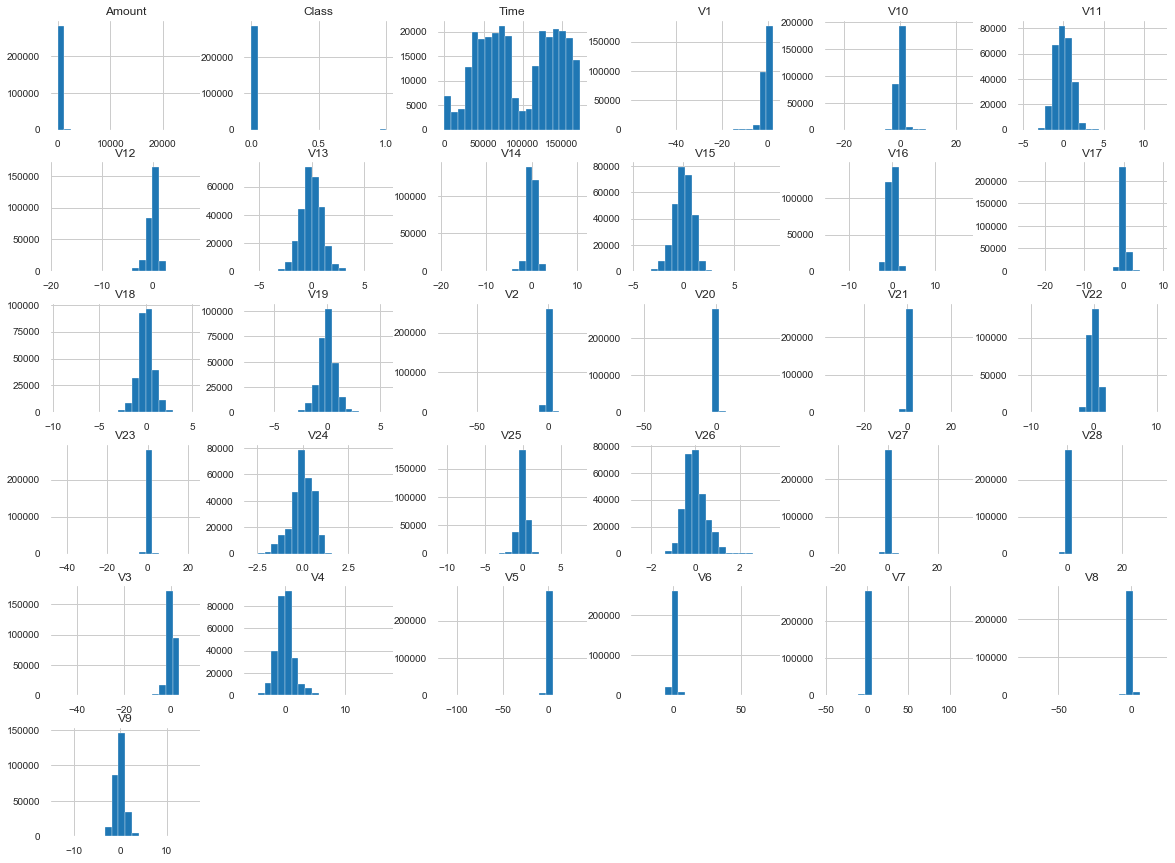

In [14]:
# Histograms of the features
# most of the data has a quasi-normal/gaussian distribution

df.hist(bins=20, figsize=(20,15))
plt.show()

Look at cross correlations between features. Most models will be fine with collinearity, but good to know this in any case. Most of my input is numerical, and my label is binary classification, so I can choose the Anova or Kendall's method. I will try the Kendall tau-b method first. This method will sort the 2 columns and compare if the X is always > or < Y. If so, the tau-b value will be 1.

Some key points to remember:
Kendall’s Tau: Calculations based on concordant and discordant pairs. Insensitive to error. P values are more accurate with smaller sample sizes. Good resource can be found here: https://online.stat.psu.edu/stat509/node/158/

This image shows which method you should choose based on your dataset:

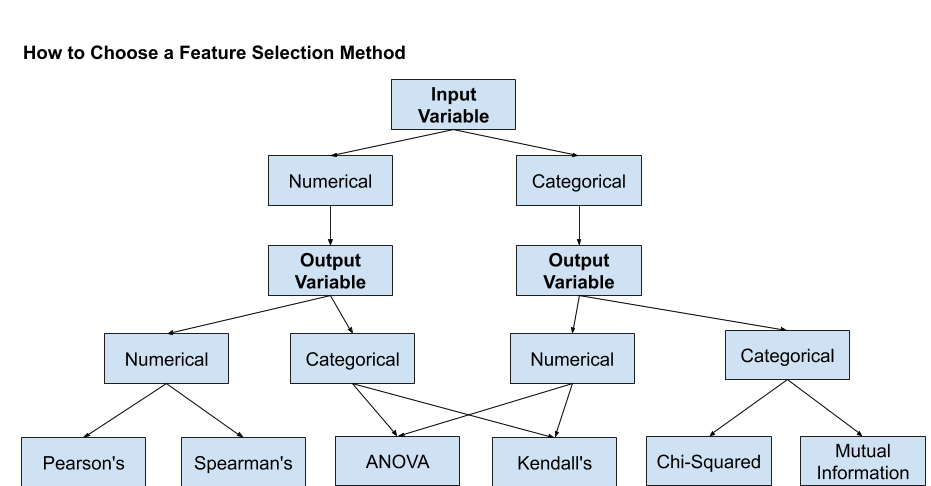

Text(0.5, 1.05, "Kendall'sCorrelation Matrix Full Data Set")

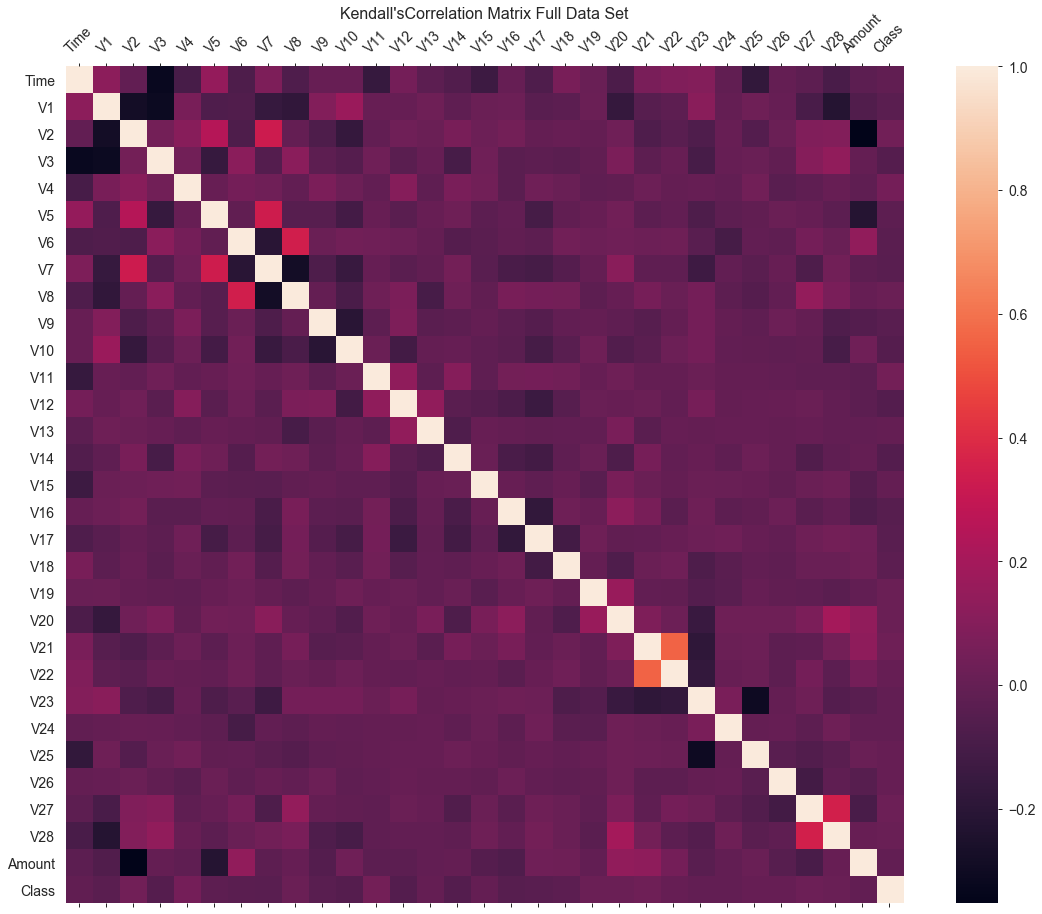

In [15]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall'sCorrelation Matrix Full Data Set", fontsize=16)

V21 and V22 show the highest tau-b score, will investigate this relationship later

In [16]:
#try some data cleansing, Amount has a few high values, so try using the log of that column instead.

temp_df = df.copy()
temp_df = temp_df.drop(['Time'], axis=1)
temp_df['Log_Amount'] = np.log(temp_df.pop('Amount')+0.001)
df = temp_df.copy()

In [17]:
from scipy.special import boxcox1p
lam = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,2,3]
for i in lam:
    print("lam:", i)
    X = df.loc[:, df.columns != 'Class']
    y = df.loc[:, df.columns == 'Class']
    norm = MinMaxScaler().fit(X)
    X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Pre", abs(skewness.Skew).mean())
    skewed_features = skewness.index
    lam_f = 0.0
    for feat in skewed_features:
        X[feat] = boxcox1p(X[feat], i)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Post", abs(skewness.Skew).mean())

lam: 0
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.924619556314968
lam: 0.1
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.752674910071598
lam: 0.2
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.591619281099101
lam: 0.3
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.4408440384190175
lam: 0.4
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 11 skewed numerical features to Box Cox transform
Post 5.019947162619655
lam: 0.5
Pre: There are 12 skewed numerical features to Box Cox transfo

In [18]:
from scipy.special import boxcox1p
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Pre", abs(skewness.Skew).mean())
skewed_features = skewness.index
pt = PowerTransformer(method='yeo-johnson').fit(X)
X = pd.DataFrame(pt.transform(X), index=X.index, columns=X.columns)
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Post", abs(skewness.Skew).mean())

Pre: There are 17 skewed numerical features to Box Cox transform
Pre 3.514581911418132
Post: There are 8 skewed numerical features to Box Cox transform
Post 1.977383868458546


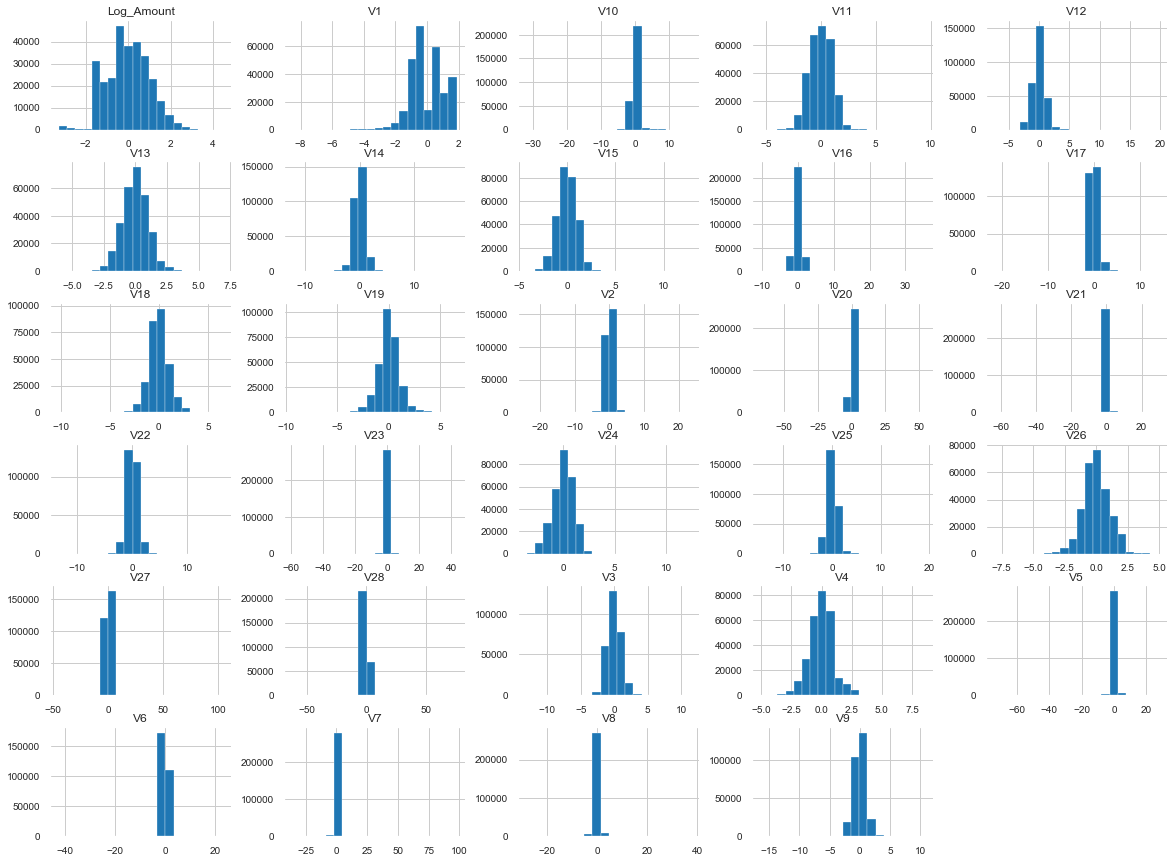

In [19]:
X.hist(bins=20, figsize=(20,15))
plt.show()

In [20]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V27,3.465013
V7,2.594561
V8,2.297578
V28,1.069187
V2,0.334850
V12,0.158932
V16,0.137436
V24,0.112492
V14,0.105965
V25,0.077895


Need to normalize the data before using boxcox or log transforms as they don't work on negative and 0 values

In [21]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
norm = MinMaxScaler().fit(X)
X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)

Pre-transform skew

In [22]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V28,11.192032
V21,3.592972
V7,2.553894
V6,1.826571
V10,1.187134
V4,0.676289
V26,0.576690
V9,0.554677
V11,0.356504
V19,0.109191


In [23]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


There are 18 skewed numerical features to Box Cox transform


In [24]:
skewness

,Skew
V28,11.192032
V21,3.592972
V7,2.553894
V6,1.826571
V10,1.187134
Log_Amount,-0.834481
V16,-1.100960
V27,-1.170203
V14,-1.995165
V20,-2.037145


In [25]:
abs(skewness.Skew).mean()

3.3656874002907333

In [26]:
from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.0
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam_f)

Post-transform skew

In [27]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V28,6.241873
V6,1.359141
V21,1.251583
V4,0.676289
V26,0.576690
V9,0.554677
V10,0.363269
V11,0.356504
V19,0.109191
V13,0.065233


In [28]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 16 skewed numerical features to Box Cox transform


In [29]:
skewness

,Skew
V28,6.241873
V6,1.359141
V21,1.251583
Log_Amount,-1.430289
V16,-1.493943
V14,-2.828641
V27,-2.878341
V3,-2.936423
V12,-3.084228
V1,-4.104152


In [30]:
abs(skewness.Skew).mean()

4.4055082951185405

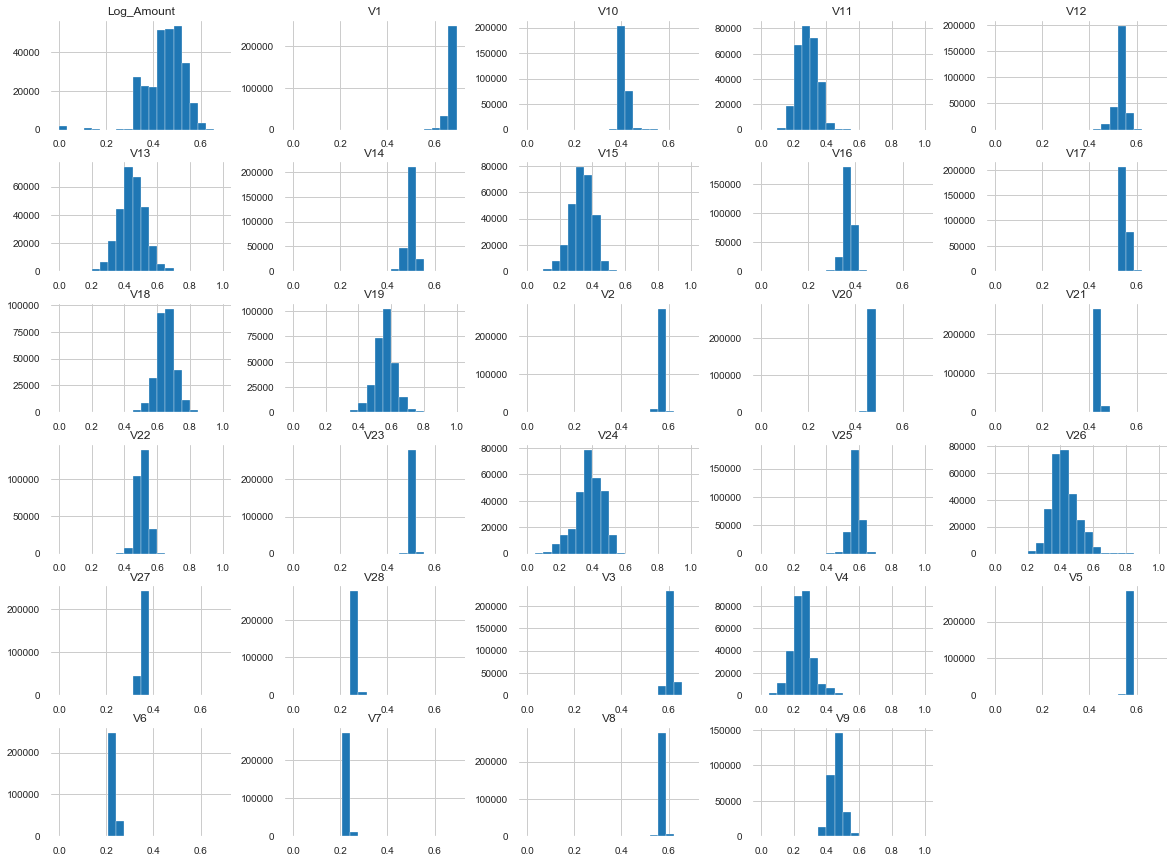

In [31]:
X.hist(bins=20, figsize=(20,15))
plt.show()

so far the MinMaxScaler, boxcox1p and log1p transforms make the data more skewed...
just utilize the PowerTransformer instead, with yeo-johnson as there are many negative values

In [32]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']

a='''
# this is incorrect approach, will lead to information leakage between train and test/val
pt_tran = 1
if (pt_tran == 1):
    pt = PowerTransformer(method='yeo-johnson', standardize=False).fit(X)
    X = pd.DataFrame(pt.transform(X), index=X.index, columns=X.columns)
    #norm = MinMaxScaler().fit(X)
    #X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)'''

Divide the dataset into features and labels and then into Train, Test and Validate datasets

In [33]:
# divide full data into features and label
spl1 = 0.3
spl2 = 0.3

OrigPct = CalcPct(y,"Original")

strat = True
if (strat == True):
    stratify=y['Class']
else:
    stratify="None"
# create train, test and validate datasets

# first split original into Train and Test+Val
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = spl1, random_state = None, shuffle=True, stratify=stratify)
# then split Test+Val into Test and Validate
# Validate will only be used in the 2 Model system (explained below)
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = spl2, random_state = None, shuffle=True)


Original
[[     0      1]
 [284315    492]]


The correct way to transform, fit the train data and transform train, test and val data based on the fit  
This does not have any effect on the performance of the model. Mean Specificity and Sensitivity are unchanged. Tested ~ 20 iterations

In [34]:
pt_tran = 1
if (pt_tran == 1):
    pt = PowerTransformer(method='yeo-johnson', standardize=False).fit(X_train)
    X_train = pd.DataFrame(pt.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test  = pd.DataFrame(pt.transform(X_test), index=X_test.index, columns=X_test.columns)
    X_val   = pd.DataFrame(pt.transform(X_val), index=X_val.index, columns=X_val.columns)

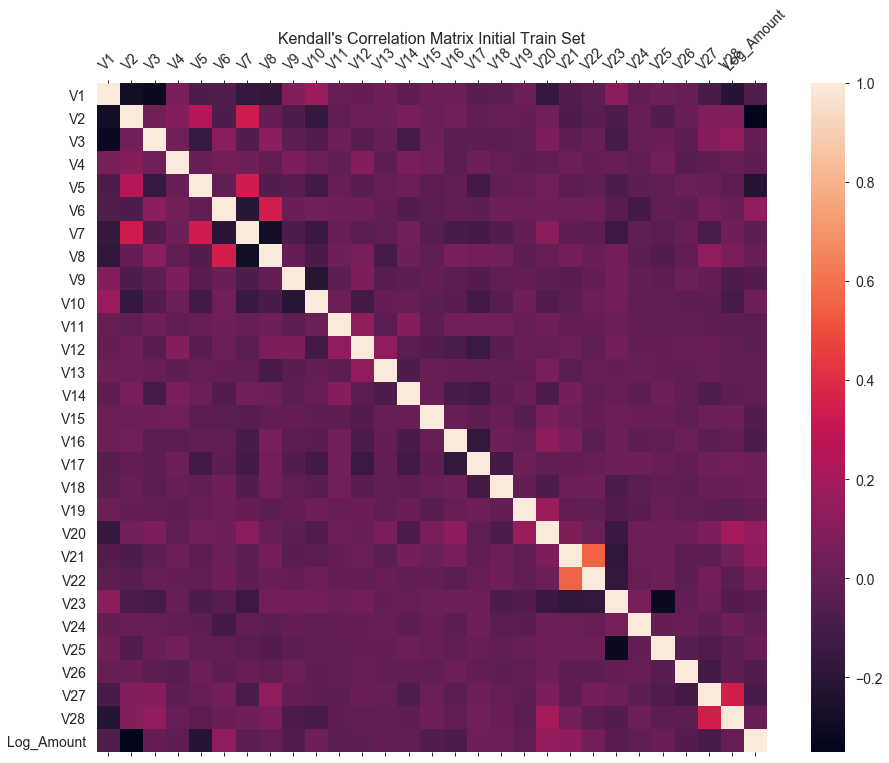

In [35]:
f = plt.figure(figsize=(16, 12))
plt.matshow(X_train.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
plt.show()

In [36]:
# prepare data for model, need to do this normalization and clipping separately for X_train, X_test and X_val 
# to avoid any contamination between Train and Test/Validate datasets
a='''
sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test),columns = X_test.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val),columns = X_val.columns)'''

a='''
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)'''

a='''
# handle any extreme fliers, set to 5 or -5
X_train = np.clip(X_train, -5, 5)
X_test = np.clip(X_test, -5, 5)
X_val = np.clip(X_val, -5, 5)'''

In [37]:
class_names=[0,1] # name  of classes 1=fraudulent transaction

y_val['Class'].value_counts()

TrainPct = CalcPct(y_train,"Train")
TestPct = CalcPct(y_test,"Train")
ValPct = CalcPct(y_val,"Train")
zeros, ones = np.bincount(y_train['Class'])

Train
[[     0      1]
 [199020    344]]
Train
[[    0     1]
 [59705   105]]
Train
[[    0     1]
 [25590    43]]


Investigate the high tau-b value between V21 and V22

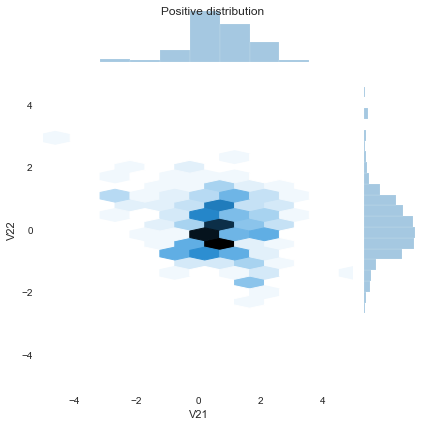

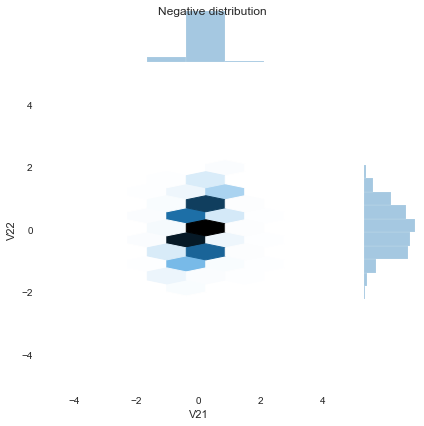

In [38]:
# Form np arrays of labels and features for jointplot charts

train_labels = np.array(y_train).flatten()
bool_train_labels = train_labels != 0 # has an extra ,1 in the bool_train_labels.shape
val_labels = np.array(y_val)
test_labels = np.array(y_test)
train_features = np.array(X_train)
val_features = np.array(X_val)
test_features = np.array(X_test)

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = X.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = X.columns)
sns.jointplot(pos_df['V21'], pos_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")
sns.jointplot(neg_df['V21'], neg_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

V21 shows a slight one-sided tail, however Kendall's correlation test is good to use here as it is a non-parametric test and can handle non-gaussian distributions like this

For a imbalanced sampling strategy, I will be using undersampling in my project as i think this is the best approach for this type of data

In [39]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

y_train = np.array(y_train).flatten()

Create some calculation and visualization functions to show the results

In [40]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [41]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred, algo):
    model_probs = model_name.predict_proba(test_features)
    n = model_name.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error") 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    y=np.reshape(test_label.to_numpy(), -1)
    fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
    cm_results.append([algo, tn, fp, fn, tp])
    cr_results.append([algo, classification_report(test_label, pred)])
    roc.append([algo, fpr, tpr, thresholds])
    # AUC score should be (Sensitivity+Specificity)/2
    print(algo + ':TEST | AUC Score: ' + str( round(metrics.auc(fpr, tpr),3 )))
    return tn, fp, fn, tp

In [42]:
def auc_roc_metrics(model, test_features, test_labels, algo): # model object, features, actual labels, name of algorithm
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only
    n = model.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]  
    model_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo) 
    return model_auc

In [43]:
def auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo):
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 3)

    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [44]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [45]:
def prediction_cutoff(model, test_features, cutoff):
    model.predict_proba(test_features)
    # to get the probability in each class, 
    # for example, first column is probability of y=0 and second column is probability of y=1.

    # the probability of being y=1
    prob1=model.predict_proba(test_features)[:,1]
    predicted=[1 if i > cutoff else 0 for i in prob1]
    return predicted

In [46]:
metrics_results = {}
roc = []
cm_results = []
cr_results = []

In [47]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
108937,1.498036,-1.703143,2.037116,-0.633190,-2.711717,0.056003,-1.897971,0.243974,-0.092156,0.953702,...,-0.269422,-0.250488,-0.108062,-0.028492,0.804118,0.277587,-0.109493,0.087280,0.048411,6.272649
7694,1.391747,0.667669,0.620839,2.185085,0.161315,-0.128281,0.128928,-0.035598,0.239025,0.464533,...,-0.171154,-0.615400,-1.666460,0.214860,-0.154197,0.089778,-0.588360,-0.060268,0.011469,4.403784
1218,1.386049,-1.625995,1.686151,-0.802774,-2.270113,0.341264,-1.586210,0.200361,-0.886325,1.046382,...,-0.067098,-0.321832,-0.337423,-0.044539,0.634413,0.298625,-0.272029,0.076820,0.043842,6.680803
24995,-0.290810,0.812351,2.016778,1.014044,0.757939,0.832063,0.672717,-0.052482,-0.172209,-0.214807,...,0.203224,-0.041013,0.361628,-0.399711,-0.756988,0.272106,-0.091867,-0.000652,-0.117058,3.768234
236923,-0.231218,0.169085,0.064111,-2.968926,0.777559,-0.757415,0.774222,-0.134153,1.198090,-1.892451,...,-0.128108,0.115982,0.608301,-0.485007,-0.856614,0.295883,-0.017178,0.136229,0.130978,1.584935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30314,-1.501151,4.120076,-2.815561,4.527065,-2.961953,-1.439726,-5.869336,2.019374,-5.264389,-7.179910,...,1.127025,1.416327,0.856371,-0.147518,0.001669,-0.038851,0.358415,1.351333,0.535662,2.421650
30442,-2.453271,5.745524,-3.107900,4.473180,-3.934808,-1.325881,-6.921218,3.734202,-5.848569,-7.870007,...,0.764766,1.606906,0.946390,-0.150103,0.011032,0.080913,0.377656,0.649686,0.489037,1.751034
123301,-1.037869,1.181309,-0.175445,1.184315,1.910857,-2.745228,0.523692,-0.095593,-0.170938,-2.812461,...,-0.187045,-0.337497,-0.829139,-0.365168,0.315787,0.459968,-0.584236,0.000105,0.134713,0.001000
16863,-1.909882,-0.070804,-1.258829,2.860657,-3.222622,0.527309,0.303130,1.077602,-2.498222,-4.141747,...,1.636095,0.855932,-0.244026,1.851107,0.229592,0.158546,-0.282359,0.222546,0.252702,9.479262


run Logistic Regression model first

In [48]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
#lr_Pred = lr.predict(X_test)
# or
lr_Pred = prediction_cutoff(lr, X_test, 0.5) # 0.5 is the default cutoff for a logistic regression test

Show the results of this model

0.9625146296605919
0.9625146296605919
Accuracy score (training): 0.965
Accuracy score (validation): 0.963
error
Confusion Matrix:
false positive pct: 3.7301454606253137
tn  fp  fn  tp
57474 2231 11 94
[[57474  2231]
 [   11    94]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59705
           1       0.04      0.90      0.08       105

    accuracy                           0.96     59810
   macro avg       0.52      0.93      0.53     59810
weighted avg       1.00      0.96      0.98     59810

Specificity = 0.9626329453144628
Sensitivity = 0.8952380952380953
LR:TEST | AUC Score: 0.971


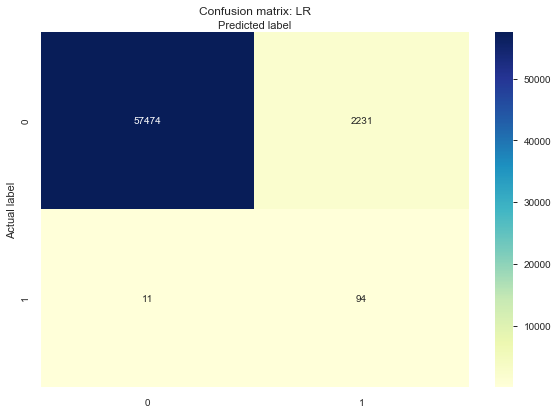

  No Skill : ROC AUC=0.500
        LR : ROC AUC=0.971


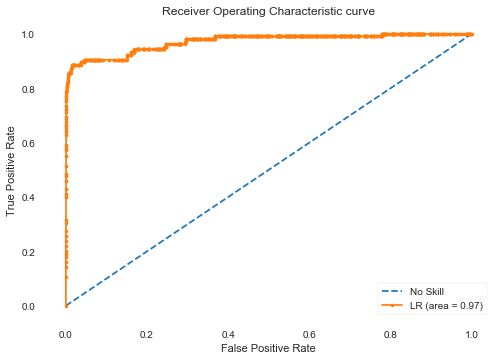

In [49]:
print(metrics.accuracy_score(y_test, lr_Pred))
tn, fp, fn, tp = display_metrics(lr, X_train, X_test, y_train, y_test, lr_Pred, 'LR')
visualize(y_test, lr_Pred, 'LR') # actual labels vs predicted labels
lr_auc = auc_roc_metrics(lr, X_test, y_test, 'LR')
metrics_results['lr'] = lr_auc

Logistic: f1=0.077 auc=0.468


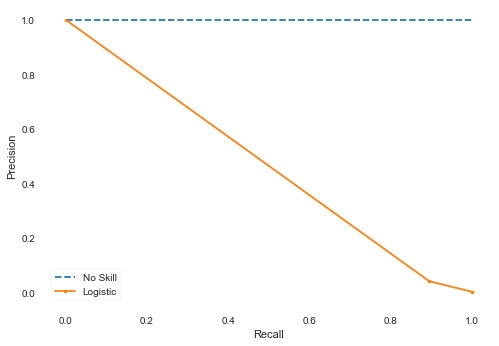

In [50]:
# useful for unbalanced data, maybe include later in metrics summary for all models

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_Pred)
lr_f1, lr_auc = f1_score(y_test, lr_Pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try the Random Forest model

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     59705
           1       0.06      0.88      0.11       105

    accuracy                           0.97     59810
   macro avg       0.53      0.93      0.55     59810
weighted avg       1.00      0.97      0.99     59810

0.9747366661093463
Accuracy score (training): 1.000
Accuracy score (validation): 0.975
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.504597893328875
tn  fp  fn  tp
58207 1498 13 92
[[58207  1498]
 [   13    92]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     59705
           1       0.06      0.88      0.11       105

    accuracy                           0.97     59810
   macro avg       0.53      0.93      0.55     59810
weighted avg       1.00      0.97      0.99     59810

Specificity = 0.9749099740390252
Sensitivity = 0.8761904761904762
RF:TEST | AUC S

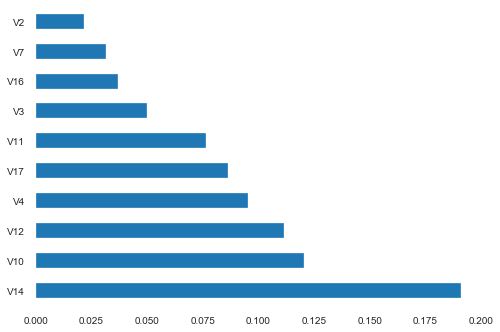

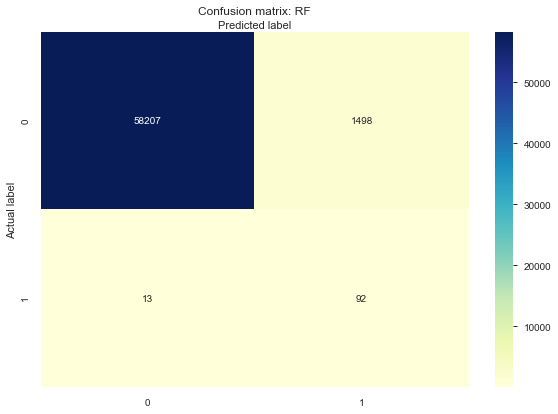

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.960


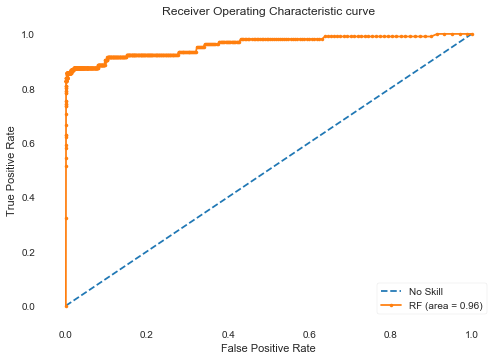

In [51]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))
tn, fp, fn, tp = display_metrics(rf, X_train, X_test, y_train, y_test, rf_Pred, 'RF')
visualize(y_test, rf_Pred, 'RF')
rf_auc = auc_roc_metrics(rf, X_test, y_test, 'RF')
metrics_results['rf'] = rf_auc

Show the results of this model

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     59705
           1       0.05      0.87      0.10       105

    accuracy                           0.97     59810
   macro avg       0.53      0.92      0.54     59810
weighted avg       1.00      0.97      0.98     59810

0.9722287242935964
Accuracy score (training): 0.959
Accuracy score (validation): 0.972
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.7537201136933622
tn  fp  fn  tp
58058 1647 14 91
[[58058  1647]
 [   14    91]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     59705
           1       0.05      0.87      0.10       105

    accuracy                           0.97     59810
   macro avg       0.53      0.92      0.54     59810
weighted avg       1.00      0.97      0.98     59810

Specificity = 0.972414370655724
Sensitivity = 0.8666666666666667
RF2:TEST | AUC 

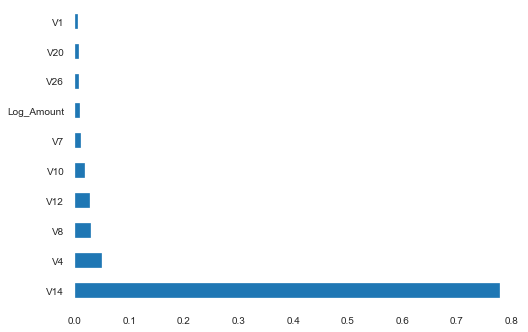

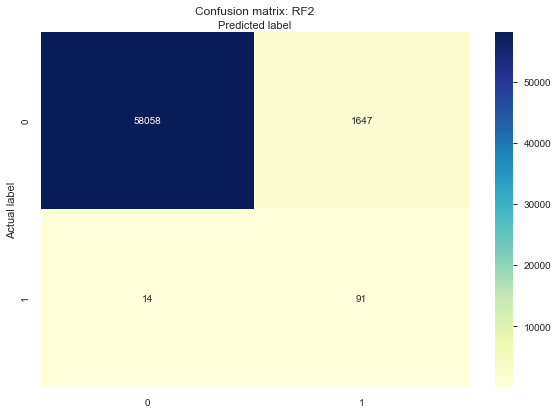

  No Skill : ROC AUC=0.500
       RF2 : ROC AUC=0.965


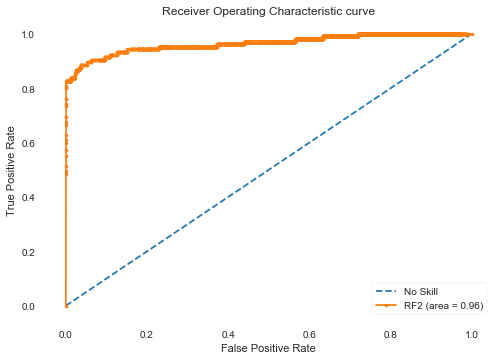

In [52]:
rf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf2.fit(X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
rf2_Pred=rf2.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf2_Pred))
tn, fp, fn, tp = display_metrics(rf2, X_train, X_test, y_train, y_test, rf2_Pred, 'RF2')
visualize(y_test, rf2_Pred, 'RF2')
rf2_auc = auc_roc_metrics(rf2, X_test, y_test, 'RF2')
metrics_results['rf2'] = rf2_auc

Try an unsupervised method using anamoly detection

In [53]:
rng = np.random.RandomState(42)
iso = IsolationForest(max_samples=100, random_state=rng, contamination=0.999, n_estimators=100, max_features=1.0)
iso.fit(X_train)
iso_Pred = iso.predict(X_test)
iso_Pred[iso_Pred == -1] = 0

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     59705
           1       0.00      0.00      0.00       105

    accuracy                           0.99     59810
   macro avg       0.50      0.50      0.50     59810
weighted avg       1.00      0.99      0.99     59810



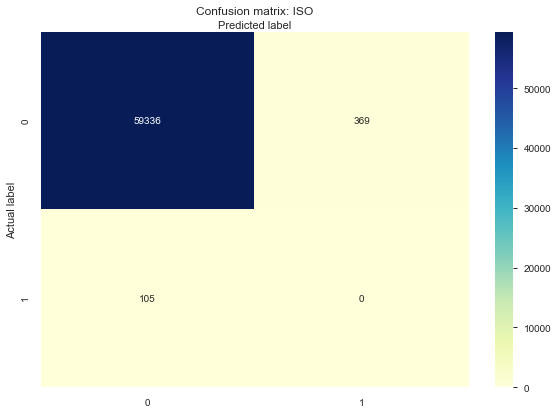

In [54]:
#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, iso_Pred))
#tn, fp, fn, tp = display_metrics(iso, X_train, X_test, y_train, y_test, iso_Pred, 'ISO')
visualize(y_test, iso_Pred, 'ISO')
#iso_auc = auc_roc_metrics(iso, X_test, y_test, 'ISO')
#metrics_results['iso'] = iso_auc

There is some variability in the results from run to run, due to random sampling and imbalanced data. This time, LogisticRegression has better prediction capability, the RandomForestClassifier test has a lot more mistakes in the False Positive category, and even a few more mistakes in the False Negative category.

Now lets try a GradientBoosting Algorithm

In [55]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=None, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0) ) #  fn = 12 and fp = 1057
# no weights gives worse false positive counts
#gb_clf.fit( X_train, y_train) # fn = 8 and fp = 2639

#use model to predict validation dataset
predictions = gb_clf.predict(X_test)


Display the results

0.9772446079250962
Accuracy score (training): 0.953
Accuracy score (validation): 0.977
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.2521317505433873
tn  fp  fn  tp
58358 1347 14 91
[[58358  1347]
 [   14    91]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59705
           1       0.06      0.87      0.12       105

    accuracy                           0.98     59810
   macro avg       0.53      0.92      0.55     59810
weighted avg       1.00      0.98      0.99     59810

Specificity = 0.9774390754543171
Sensitivity = 0.8666666666666667
GB:TEST | AUC Score: 0.963


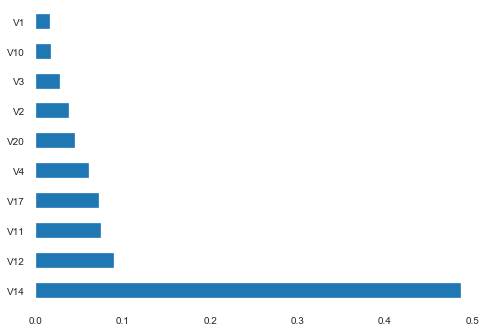

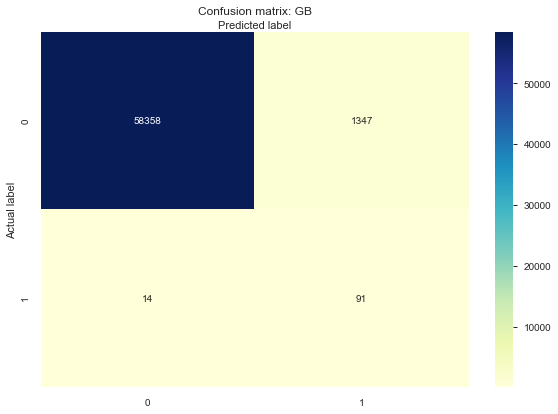

  No Skill : ROC AUC=0.500
        GB : ROC AUC=0.963


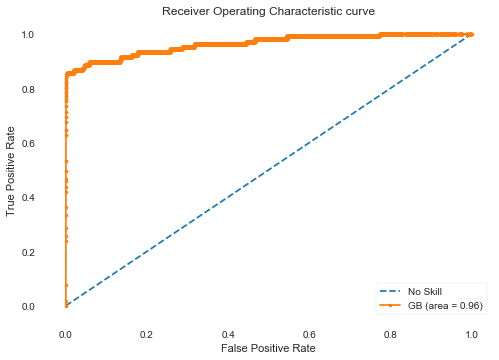

In [56]:
tn, fp, fn, tp = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions, 'GB')
visualize(y_test, predictions, 'GB')
gb_auc = auc_roc_metrics(gb_clf, X_test, y_test, 'GB')
metrics_results['gb'] = gb_auc

After tweaking the parameters, i can get a decent result from GradientBoostingClassifier. Changing the weights has a very large influence on the number of errors (FN and FP). Since this data is mostly 0 values, decreasing the weight of a true value vs a false value will decrease the FN, doing the opposite will decrease the FP. For one example run:  the sample_weight=np.where(y_train == 1,0.37,1.0) gives 13 FN and 795 FP. sample_weight=np.where(y_train == 1,0.1,1.0) gives 17 FN and 217 FP

My next idea is to run 2 consecutive models consecutively. 1st model should have low false negatives to catch (almost) all the actual positives, even if the number of false positives is high. Then only take these records with a predicted 1 value (should only be a few thousand), as the input for the next model. 2nd test should have low false positives to weed out the actual negatives. Will use the Validate dataset on the 2 models created from the Train and Test datasets

Here are some details on the new model:

Current:
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M2(Filtered Test)
                Test
                
To Do:               
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M1 and M2(Validate)
                Test
                Validate

Can also try the inverse, but think that option will have less chance of success.

1st step

build the 1st model to be used later on the validate dataset

In [57]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=None, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf1.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf1.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 5.0

#use model to predict validation dataset
predictions = gb_clf1.predict(X_test) 

0.9369837819762582
Accuracy score (training): 0.964
Accuracy score (validation): 0.937
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 6.279886306637686
tn  fp  fn  tp
55949 3756 13 92
[[55949  3756]
 [   13    92]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     59705
           1       0.02      0.88      0.05       105

    accuracy                           0.94     59810
   macro avg       0.51      0.91      0.51     59810
weighted avg       1.00      0.94      0.97     59810

Specificity = 0.9370906959216146
Sensitivity = 0.8761904761904762
GB1 Train **:TEST | AUC Score: 0.965


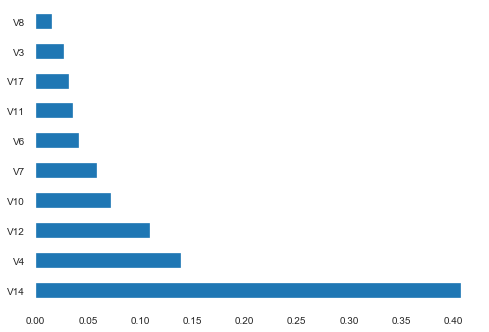

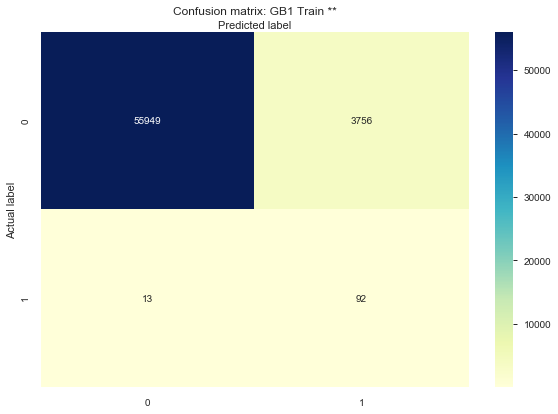

  No Skill : ROC AUC=0.500
GB1 Train ** : ROC AUC=0.965


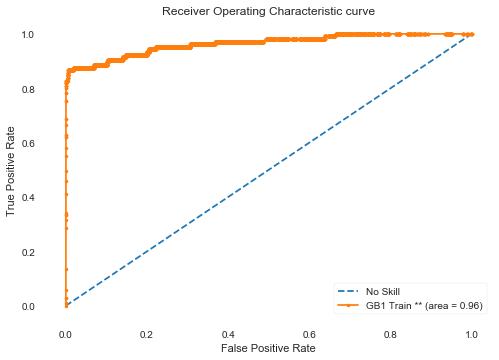

In [58]:
algo = 'GB1 Train **'
tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_train, X_test, y_train, y_test, predictions, algo)
visualize(y_test, predictions, algo)
gb1_auc = auc_roc_metrics(gb_clf1, X_test, y_test, algo)
metrics_results['gb1_train'] = gb1_auc

2nd step takes all the Predicted Positives (the misclassified FP from upper right (~ 14000) plus the TP (since we won't use the actual value until the validation step)) and reprocesses these using a different model. The other 2 squares (Predicted 0's) are not included in the 2nd model, since we already have a low False negative result, so the initial predicted 0s don't change. Will need to add those back into the final results at the end.

Add 1st model prediction column to X_test for filtering

In [59]:
X_test['Prediction'] = predictions

select rows with prediction of 1

In [60]:
yes_ind = X_test[X_test['Prediction'] == 1].index

Create 2nd train dataset from 1st dataset where the prediction was 1

In [61]:
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]

In [62]:
y_test

,Class
18112,0
258043,0
242074,0
28410,0
280844,0
...,...
108493,0
225067,0
207827,0
236319,0


clean up the X_test dataset for future modeling, means remove the Prediction column

In [63]:
X_test = X_test.drop(['Prediction'], axis=1)

In [64]:
X2_test = X2_test.drop(['Prediction'], axis=1)

Look at the prediction values from the first model (preda_1) for the rows with a predicted label of 0

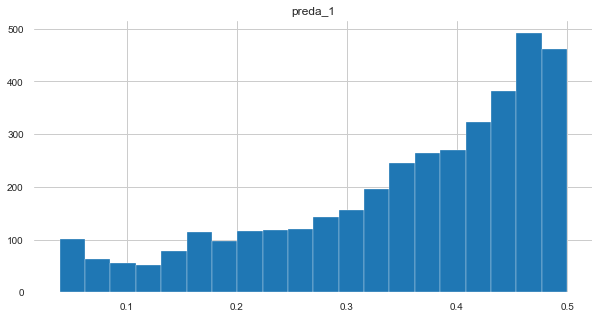

In [65]:
proba = gb_clf1.predict_proba(X2_test) 
pred = gb_clf1.predict(X2_test) 
df = pd.DataFrame(data=proba[:,0], columns=["preda_1"])
df.hist(bins=20, figsize=(10,5))
plt.show()

Then we look at the ROC curve

  No Skill : ROC AUC=0.500
PredictedPositives : ROC AUC=0.991


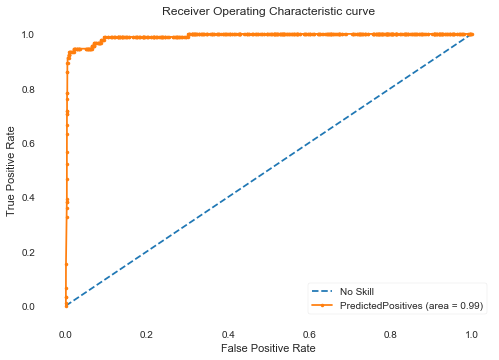

0.991

In [66]:
algo = 'PredictedPositives'
test_labels = y2_test
ns_probs = [0 for _ in range(len(test_labels))]
auc_roc_metrics_plots(proba[:,1], ns_probs, test_labels, algo)

Next we build the 2nd model to be used model later on the validate dataset and look at the output

0.32588357588357586
Accuracy score (training): 0.969
Accuracy score (validation): 0.326
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 67.41164241164242
tn  fp  fn  tp
1162 2594 0 92
[[1162 2594]
 [   0   92]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47      3756
           1       0.03      1.00      0.07        92

    accuracy                           0.33      3848
   macro avg       0.52      0.65      0.27      3848
weighted avg       0.98      0.33      0.46      3848

Specificity = 0.3093716719914803
Sensitivity = 1.0
GB2 Train **:TEST | AUC Score: 0.99


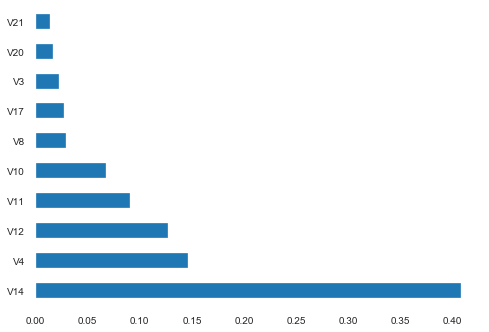

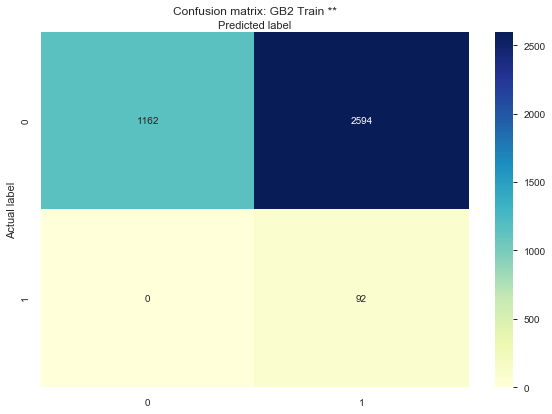

  No Skill : ROC AUC=0.500
GB2 Train ** : ROC AUC=0.990


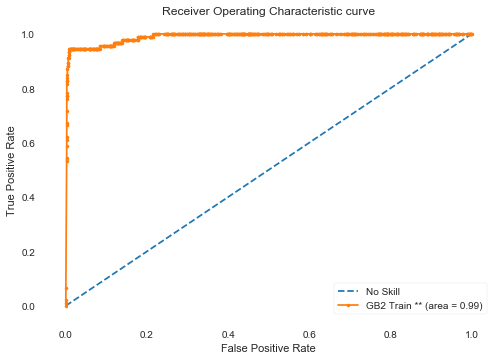

2 Step Final Confusion Matrix:
57111 2594
13 92


Text(0.5, 352.48, 'Predicted label')

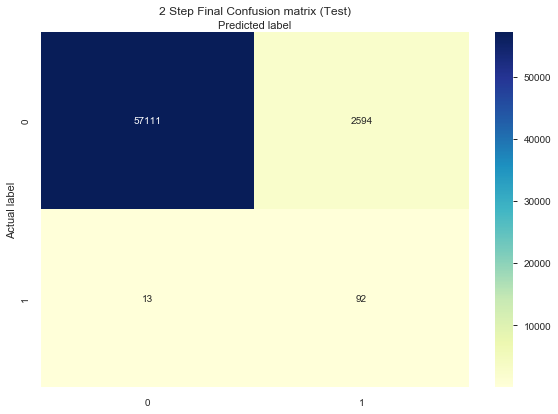

In [67]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=10, 
                                    max_depth=3, random_state=None, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf2.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf2.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 0.1 but should be > 1 to work correctly

#use model to predict validation dataset
predictions = gb_clf2.predict(X2_test) 

algo = 'GB2 Train **'
tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_test, y_train, y2_test, predictions, algo)

visualize(y2_test, predictions, algo)

gb2_auc = auc_roc_metrics(gb_clf2, X2_test, y2_test, algo)
metrics_results['gb2_train'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Test)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Now that we have built the 2 models from the test dataset, run the untouched validate dataset through both of them to get an unbiased result to compare against

In [68]:
# run the validate dataset through the first model
algo = '2-Step'
predictions1 = gb_clf1.predict(X_val)
predictions_proba1 = gb_clf1.predict_proba(X_val)
X1_val_final = X_val.copy()
X1_val_final=X1_val_final.join(y_val)
X1_val_final['Proba_1'] = predictions_proba1[:,1]
#X1_val_final
#X_val = X_val.sort_index(axis = 0) 

0.9381266336363282
Accuracy score (training): 0.937
Accuracy score (validation): 0.938
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 6.179534194202786
tn  fp  fn  tp
24006 1584 2 41
[[24006  1584]
 [    2    41]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     25590
           1       0.03      0.95      0.05        43

    accuracy                           0.94     25633
   macro avg       0.51      0.95      0.51     25633
weighted avg       1.00      0.94      0.97     25633

Specificity = 0.9381008206330598
Sensitivity = 0.9534883720930233
GB1 Validate **:TEST | AUC Score: 0.98


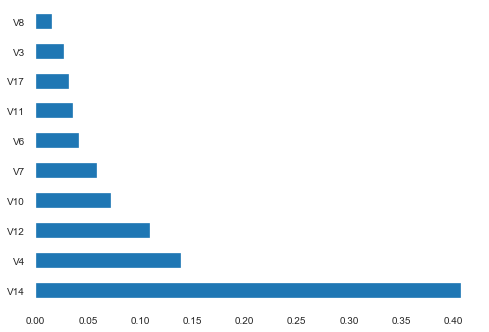

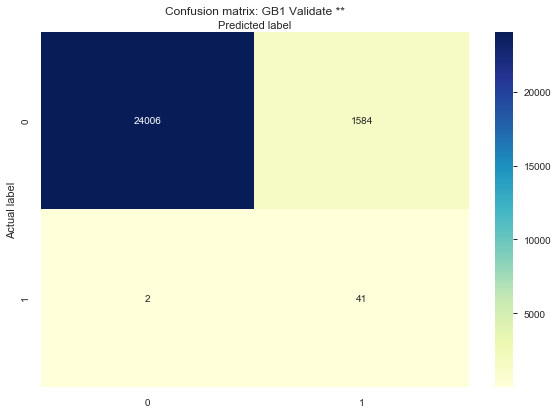

  No Skill : ROC AUC=0.500
GB1 Validate ** : ROC AUC=0.980


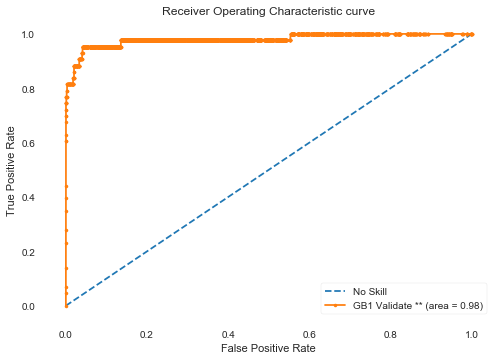

In [69]:
# adding this
# use both models to predict final validation dataset
algo = 'GB1 Validate **'
tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_test, X_val, y_test, y_val, predictions1, algo) 
visualize(y_val, predictions1, algo)
gb1_auc = auc_roc_metrics(gb_clf1, X_val, y_val, algo)
metrics_results['gb1_validate'] = gb1_auc


In [70]:

X_val['Prediction'] = predictions1

yes_ind = X_val[X_val['Prediction'] == 1].index

X2_val = X_val.loc[yes_ind]
y2_val = y_val.loc[yes_ind]
X2_val = X2_val.drop(['Prediction'], axis=1)
# run the validate dataset through the second model
predictions2 = gb_clf2.predict(X2_val)

X2_val_final = X2_val.copy()
X2_val_final.join(y2_val)
predictions_proba2 = gb_clf2.predict_proba(X2_val)
# validate the join!!
X2_val_final['Proba_2'] = predictions_proba2[:,1]
X2_val_final

cols_to_use = X2_val_final.columns.difference(X1_val_final.columns)
X_val_final = X1_val_final.join(X2_val_final[cols_to_use], how='left', lsuffix='_1', rsuffix='_2')
# rowwise action (axis=1)
X_val_final.loc[X_val_final['Proba_2'].isnull(),'Proba_2'] = X_val_final['Proba_1']
#X_val_final['Proba_2'].fillna(df['Proba_1'])
#X_val_final.query("Proba_1 != Proba_2")

#remove this column for use later
X_val = X_val.drop(['Prediction'], axis=1)

0.3261538461538461
Accuracy score (training): 0.969
Accuracy score (validation): 0.326
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 67.38461538461539
tn  fp  fn  tp
489 1095 0 41
[[ 489 1095]
 [   0   41]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47      1584
           1       0.04      1.00      0.07        41

    accuracy                           0.33      1625
   macro avg       0.52      0.65      0.27      1625
weighted avg       0.98      0.33      0.46      1625

Specificity = 0.3087121212121212
Sensitivity = 1.0
GB2 Validate **:TEST | AUC Score: 0.941


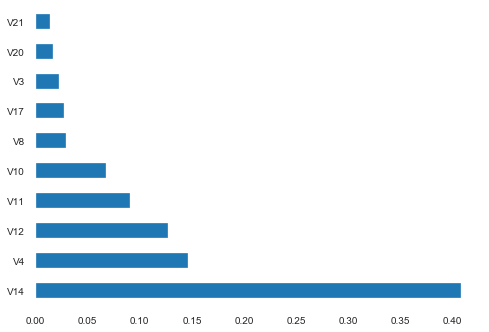

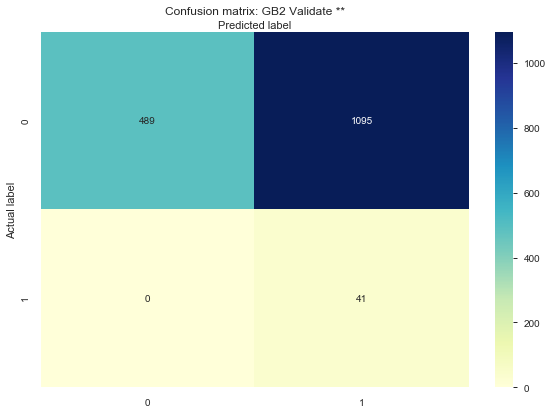

  No Skill : ROC AUC=0.500
GB2 Validate ** : ROC AUC=0.941


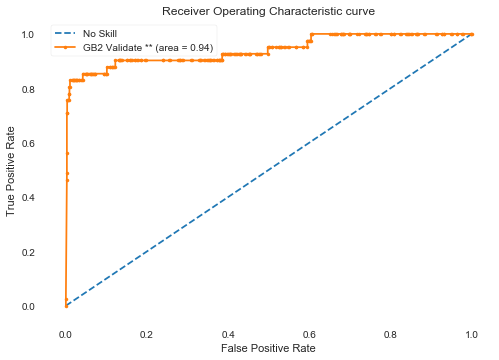

2 Step Final Confusion Matrix:
24495 1095
2 41
Specificity = 0.9572098475967175
Sensitivity = 0.9534883720930233
2 Step Algorithm:TEST | AUC Score: 0.955


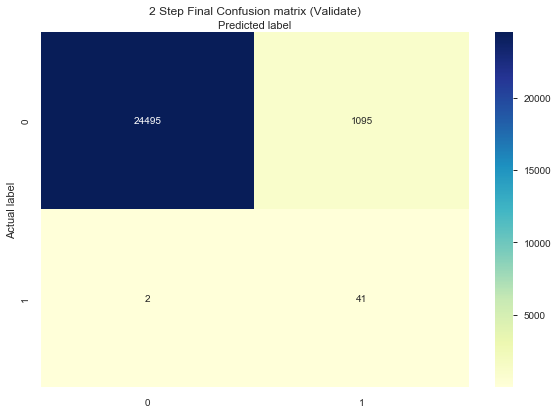

In [71]:
algo = 'GB2 Validate **'
tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_val, y_train, y2_val, predictions2, algo) 
visualize(y2_val, predictions2, algo)
gb2_auc = auc_roc_metrics(gb_clf2, X2_val, y2_val, algo)
metrics_results['gb2_validate'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Validate)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

algo = '2-Step'
Specificity = (tn+tn1)/(tn+tn1+fp)
Sensitivity = tp/(tp+fn+fn1)

print("Specificity =", Specificity)
print("Sensitivity =", Sensitivity)

print('2 Step Algorithm' + ':TEST | AUC Score: ' + str( round( (Specificity+Sensitivity)/2,3 )))

cm_results.append([algo, (tn+tn1), fp, (fn+fn1), tp])
# HERE
#two_step_auc = auc_roc_metrics(gb_clf, X_test, y_test, '2-Step')

  No Skill : ROC AUC=0.500
    2-Step : ROC AUC=0.981


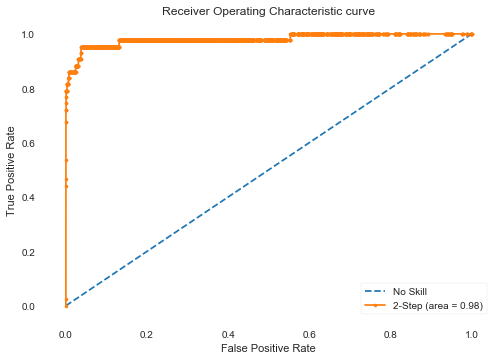

In [72]:
# try to combine the 2 models into one AUC score, however not sure that the proba values from 2 different models can be combined 

test_labels = X_val_final['Class']
ns_probs = [0 for _ in range(len(test_labels))]
model_probs = X_val_final['Proba_2']
model_pred=[1 if i > 0.50 else 0 for i in model_probs]

two_step_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo)

metrics_results['2-step'] = two_step_auc

cr_results.append([algo, classification_report(test_labels, model_pred)])

In [73]:
y=np.reshape(test_labels.to_numpy(), -1)
fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
roc.append([algo, fpr, tpr, thresholds])

The 2 step process has the highest sensitivity (and specificity) between the models. The 2 step process also improves the overall model prediction of positives by a large amount (FP/TP ratio from above 10x to below 2x). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 10x FP/TP ratio.

Next will try a few Neural Networks

In [74]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

Using TensorFlow backend.


Adding swish activation function code for possible use later, can compare to relu, etc

In [75]:
# create new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [76]:
# add this function to the list of Activation functions
get_custom_objects().update({'swish': Activation(swish)})

Create the models to be used layer, using Sequential()

In [77]:
def create_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [78]:
def create_simple_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [79]:
def create_complex_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=20, kernel_initializer='uniform', activation='relu'),
        Dense(units=24, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [80]:
def create_cnn(input_shape):
    model = Sequential()
    #model.add(Conv1D(32, 2, activation = 'relu', input_shape = input_shape))
    #model.add(Conv1D(filters=32, kernel_size=2, input_shape = (30) ))
    #model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='swish', padding='valid', input_shape=input_shape ))
    model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='relu', padding='valid', input_shape=input_shape ))
    # TypeError: 'int' object is not iterable
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

run the CNN model

Input shape: (29, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 32)            352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 64)             256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (Non

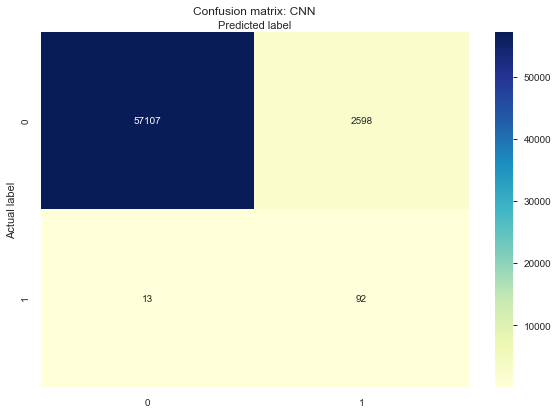

  No Skill : ROC AUC=0.500
       CNN : ROC AUC=0.968


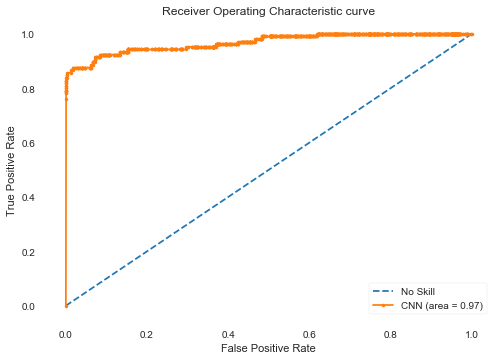

In [81]:
input_shape = (X_train.shape[1], 1)
input_dim = X_train.shape[1]
print("Input shape:", input_shape)
clf = create_cnn(input_shape)
# NameError: name 'input_shape' is not defined

# reshape data for CNN expected input
nrows, ncols = X_train.shape # (602,30)
X_train_arr = X_train.copy().to_numpy()
y_train_arr = y_train.copy()
X_train_arr = X_train_arr.reshape(nrows, ncols, 1)

nrows, ncols = X_test.shape # (602,30)
X_test_arr = X_test.copy().to_numpy()
y_test_arr = y_test.copy()
X_test_arr = X_test_arr.reshape(nrows, ncols, 1)

#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# Let's train the model using RMSprop
#clf.compile(loss='binary_crossentropy',
#              optimizer=opt,
#              metrics=['accuracy'])
# or
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

clf.summary()

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=16, epochs=20, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
# or
clf.fit(X_train_arr, y_train_arr, epochs=200, verbose=verbose, sample_weight=np.where(y_train_arr == 1,1.0,1.0).flatten())
# check model metrics
score = clf.evaluate(X_train_arr, y_train_arr, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test_arr, y_test_arr, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test_arr, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test_arr, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (CNN)") 
print(classification_report(y_test_arr, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train_arr, X_test_arr, y_train_arr, y_test_arr, yhat_classes, 'CNN')
visualize(y_test_arr, yhat_classes, 'CNN')
cnn_auc = auc_roc_metrics(clf, X_test_arr, y_test_arr, 'CNN')
metrics_results['cnn'] = cnn_auc

In [82]:
X_train.shape[1]

29

Now run the basic DNN (Deep Neural Network)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_4 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 1,695
Trainable params: 1,695
Non-trainable params: 0
____________________________________________________

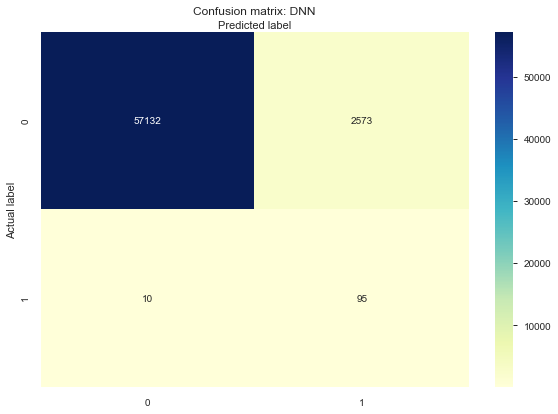

  No Skill : ROC AUC=0.500
       DNN : ROC AUC=0.970


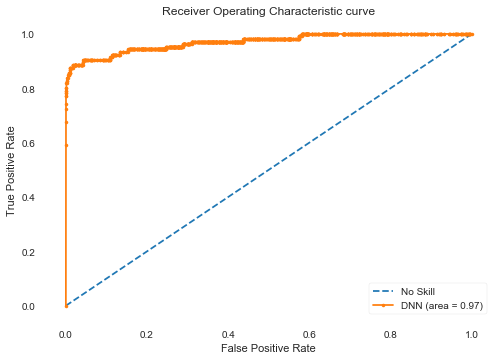

In [83]:
clf = create_dnn(input_dim)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=20, verbose=verbose, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN')
visualize(y_test, yhat_classes, 'DNN')
dnn_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN')
metrics_results['dnn'] = dnn_auc

Results from Deep NN are better than 1 step/model examples, but overall not quite as good as the 2 step/model process. I can get the sensitivity to be as good, but in that case, the specificity is much lower. As more data is added or processed through this DNN, the results should improve, maybe eventually beating the 2 step model. However, it seems that increasing the number of epochs will weight the model to higher false negatives, similar to using sample weights for the GBM model:

**sample_weight=np.where(y_train == 1,0.1,1.0)**

**giving a 1 in the training data 10 times the weight or inflence of a 0**

For now, we will keep the number of epochs at 5.
Weighting has the same effect on this DNN as it had on the GBM. Best all around result with 

sample_weight=np.where(y_train == 1,0.1,1.0).flatten()

Look at simpler and more complex examples of a DNN for comparison

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 19        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
688/688 [==============================] - 0s 31us/step

And the Train Score is  97.09302186965942 %
59810/59810 [==============================] - 0s 5us/step

And the Test Score is  95.17137408256531 %
Classification Report (DNN Simple)
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     59705
           1       0.03      0.90     

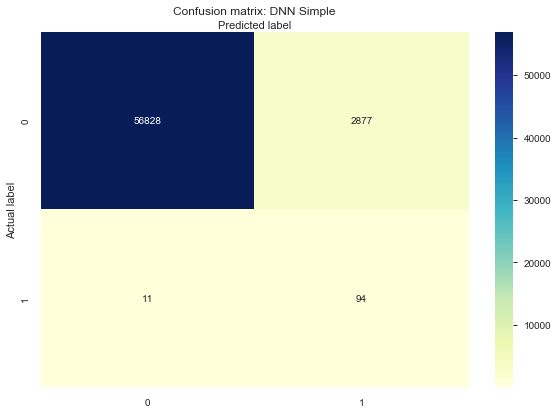

  No Skill : ROC AUC=0.500
DNN-Simple : ROC AUC=0.973


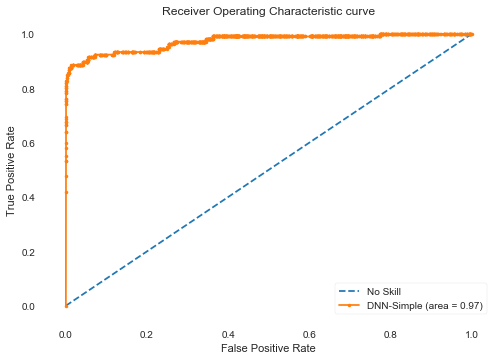

In [84]:
clf = create_simple_dnn(input_dim)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=32, epochs=32, verbose=verbose, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN Simple)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Simple')
visualize(y_test, yhat_classes, 'DNN Simple')
dnn_simple_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Simple')
metrics_results['dnn_simple'] = dnn_simple_auc

This DNN is successful at reducing the FP/TP ratio. This is expected as a Neural Network can decide on its own rules to include based on the input data. Below I try other more and less complex methods, but so far the results are not as good.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_12 (Dense)             (None, 18)                306       
_________________________________________________________________
dropout_5 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                570       
_________________________________________________________________
dense_14 (Dense)             (None, 28)                868       
_________________________________________________________________
dropout_6 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)               

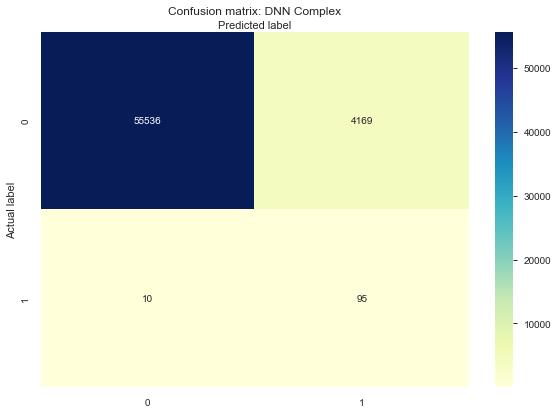

  No Skill : ROC AUC=0.500
DNN-Complex : ROC AUC=0.945


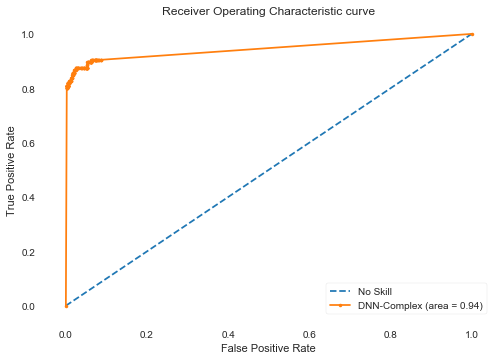

In [85]:
clf = create_complex_dnn(input_dim)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=32, verbose=verbose, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN complex)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Complex')
visualize(y_test, yhat_classes, 'DNN Complex')
dnn_complex_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Complex')
metrics_results['dnn_complex'] = dnn_complex_auc

In [86]:
def create_autoencoder(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=15, kernel_initializer='uniform', input_dim=input_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5)),
        Dense(units=7, kernel_initializer='uniform', activation='relu'),
        Dense(units=7, kernel_initializer='uniform', activation='tanh'),
        Dense(units=31, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 15)                450       
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_23 (Dense)             (None, 31)                248       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 32        
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
688/688 [==============================] - 0s 50us/step

And the Train Score is  97.23837375640869 %
59810/59810 [========

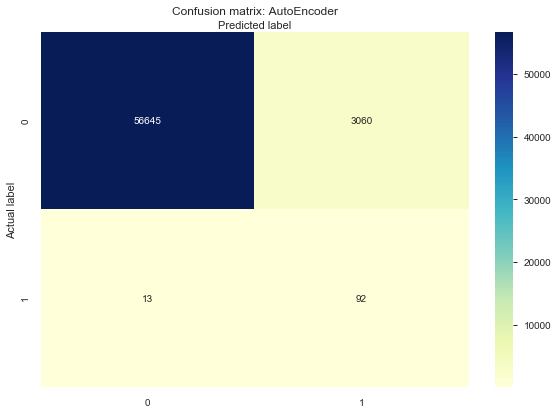

  No Skill : ROC AUC=0.500
AutoEncoder : ROC AUC=0.971


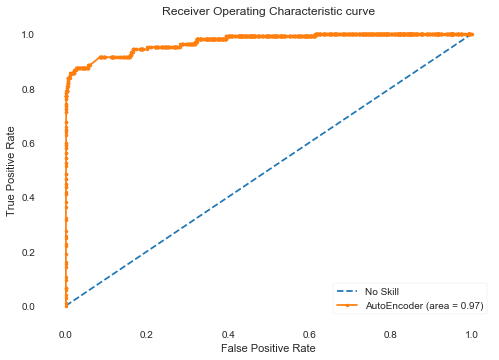

In [87]:
clf = create_autoencoder(input_dim)
clf.summary()
#clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=32, epochs=32, shuffle=True)#, validation_data=(X_test, X_test))
clf.fit(X_train, y_train, batch_size=16, epochs=32, verbose=verbose, sample_weight=np.where(y_train == 1,2.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=32)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=32)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (AutoEncoder)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'AutoEncoder')
visualize(y_test, yhat_classes, 'AutoEncoder')
autoencoder_auc = auc_roc_metrics(clf, X_test, y_test, 'AutoEncoder')
metrics_results['autoencoder'] = autoencoder_auc

In [88]:
print("AUC comparisons")
print(metrics_results)

AUC comparisons
{'lr': 0.971, 'rf': 0.96, 'rf2': 0.965, 'gb': 0.963, 'gb1_train': 0.965, 'gb2_train': 0.99, 'gb1_validate': 0.98, 'gb2_validate': 0.941, '2-step': 0.981, 'cnn': 0.968, 'dnn': 0.97, 'dnn_simple': 0.973, 'dnn_complex': 0.945, 'autoencoder': 0.971}


<pre>
AUC comparisons between all the models:

{'lr': 0.965, 'rf': 0.975, 'gb': 0.975, 'gb1_train': 0.979, 'gb2_train': 0.967, 'gb1_validate': 0.99, 'gb2_validate': 0.974, '2-step': 0.941, 'dnn': 0.964, 'dnn_simple': 0.978, 'dnn_complex': 0.939, 'autoencoder': 0.956}
{'lr': 0.968, 'rf': 0.979, 'gb': 0.976, 'gb1_train': 0.975, 'gb2_train': 0.968, 'gb1_validate': 0.991, 'gb2_validate': 0.978, '2-step': 0.957, 'dnn': 0.983, 'dnn_simple': 0.981, 'dnn_complex': 0.961, 'autoencoder': 0.952}

Side by Side comparisions of all models


    LR
    [[64954  3280]
     [   15   104]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.87      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.91      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    RF
    [[66254  1980]
     [   13   106]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.97      0.99     68234
               1       0.05      0.89      0.10       119

        accuracy                           0.97     68353
       macro avg       0.53      0.93      0.54     68353
    weighted avg       1.00      0.97      0.98     68353


    GB
    [[66732  1502]
     [   16   103]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.98      0.99     68234
               1       0.06      0.87      0.12       119

        accuracy                           0.98     68353
       macro avg       0.53      0.92      0.55     68353
    weighted avg       1.00      0.98      0.99     68353


    2Step
    [[45336  162]
     [   5    67]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.99      0.99     45377
               1       0.36      0.93      0.52        72
        accuracy                           0.??     45449
       macro avg       0.57      0.96      0.71     45449
    weighted avg       1.00      0.99      0.99     45449


    DNN
    [[64991  3243]
     [    9   110]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.92      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.94      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    DNN Simple
    [[63011  5223]
     [    6   113]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.92      0.96     68234
               1       0.02      0.95      0.04       119

        accuracy                           0.92     68353
       macro avg       0.51      0.94      0.50     68353
    weighted avg       1.00      0.92      0.96     68353


    AutoEncoder
    60277 7957 7 112
    [[60277  7957]
     [    7   112]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.88      0.94     68234
               1       0.01      0.94      0.03       119

        accuracy                           0.88     68353
       macro avg       0.51      0.91      0.48     68353
    weighted avg       1.00      0.88      0.94     68353
    
    
    CNN
    [[64761  3473]
     [   14   105]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.97     68234
               1       0.03      0.88      0.06       119

        accuracy                           0.95     68353
       macro avg       0.51      0.92      0.52     68353
    weighted avg       1.00      0.95      0.97     68353




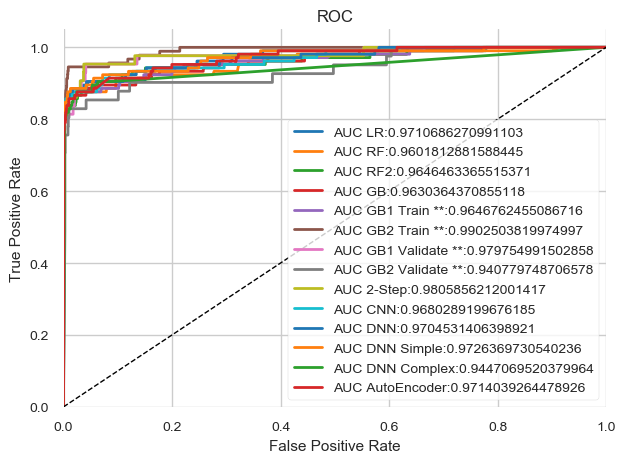

In [89]:
plt.figure(figsize=(7,5),dpi=100)

for i in range(0,len(roc)):
    #print('roc[0]', roc[0])
    #print('roc[i]', roc[i])
    auc1 = auc(roc[i][1],roc[i][2])
    plt.plot(roc[i][1],roc[i][2], label="AUC {0}:{1}".format(roc[i][0], auc1), linewidth=2)
    
plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

Final confusion matrix results comparing the different algorithms. The items marked with ** are interim results for the 2 step process, and are not for comparison, only shown for reference. As you can see, both the FP and FN values are best for the 2 step process. This process is the most efficient at finding fraudulent transactions, and has the least amount of noise (FP).

number of Actual 0 and 1 in the final validation dataset for 2-test model
"1" total should match the FN + TP

In [90]:
y_val['Class'].value_counts()

0    25590
1       43
Name: Class, dtype: int64

number of Actual 0 and 1 in the final test dataset for all other models
"1" total should match the FN + TP

In [91]:
y_test['Class'].value_counts()

0    59705
1      105
Name: Class, dtype: int64

Here are the final results in tabular form. 

In [92]:
final_results = pd.DataFrame(cm_results, columns=('algo','TN','FP','FN','TP')) 
#sp = round((tn1 + tn2)/(tn1 + tn2 +fp2), 3)
#se = round(tp2/(tp2 + fn1 + fn2), 3)
final_results['SP'] = round(final_results['TN']/(final_results['TN'] + final_results['FP']), 3)
final_results['SE'] = round(final_results['TP']/(final_results['TP'] + final_results['FN']), 3)
final_results['Avg'] = (final_results['SP'] + final_results['SE'])/2
print('test, val, split settings')
print(spl1,spl2)
print('test, val, split sizes')
print( (spl1-spl1*spl2), (spl1*spl2) )
filtered = final_results[~final_results.algo.str.contains('a', regex= True, na=False)]
sort = filtered.sort_values(filtered.columns[7], ascending = False)
print(sort)
sort.to_csv('c:\\DataScience\\Repo\\Imbalanced_data\\CreditCardFraud\\working\\results.csv', sep=',', mode='a', encoding='utf-8', header=True)

test, val, split settings
0.3 0.3
test, val, split sizes
0.21 0.09
           algo     TN    FP  FN  TP     SP     SE     Avg
8        2-Step  24495  1095   2  41  0.957  0.953  0.9550
10          DNN  57132  2573  10  95  0.957  0.905  0.9310
0            LR  57474  2231  11  94  0.963  0.895  0.9290
1            RF  58207  1498  13  92  0.975  0.876  0.9255
11   DNN Simple  56828  2877  11  94  0.952  0.895  0.9235
3            GB  58358  1347  14  91  0.977  0.867  0.9220
2           RF2  58058  1647  14  91  0.972  0.867  0.9195
12  DNN Complex  55536  4169  10  95  0.930  0.905  0.9175
9           CNN  57107  2598  13  92  0.956  0.876  0.9160
13  AutoEncoder  56645  3060  13  92  0.949  0.876  0.9125


In [93]:
print('mean(Avg):', filtered['Avg'].mean())
print(pt.get_params())

mean(Avg): 0.92515
{'copy': True, 'method': 'yeo-johnson', 'standardize': False}


In [94]:
f = open('c:\\DataScience\\Repo\\Imbalanced_data\\CreditCardFraud\\working\\averages.txt', 'a+')
f.write(str(filtered['Avg'].mean()))
f.write("\n")
f.close()

In [95]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-09-08 18:11:04.713231
End:  2020-09-08 18:16:11.729490


things to try, calculate optimal weights

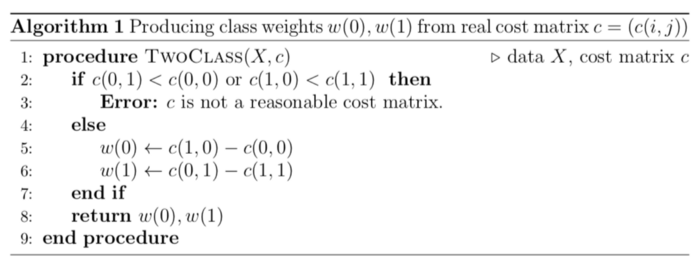

reference: https://medium.com/rv-data/how-to-do-cost-sensitive-learning-61848bf4f5e7